In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
## quitar esta parte porque debemos cargar los datos directamente modificados
df = pd.read_csv("data1.csv",low_memory=False)
df.head(3)
df1 = df.drop('Unnamed: 0', axis=1)
df1['Furnace..kW.'] = df1['Furnace.1..kW.'] + df1['Furnace.2..kW.']
df1['Kitchen..kW.'] = df1['Kitchen.12..kW.'] + df1['Kitchen.14..kW.'] + df1['Kitchen.38..kW.']
df1.drop(['Furnace.1..kW.', 'Furnace.2..kW.', 'Kitchen.12..kW.', 'Kitchen.14..kW.', 'Kitchen.38..kW.'], axis =1, inplace=True)
df1['time'] = pd.to_datetime(df1['time'])
df1.set_index('time', inplace=True)


In [3]:
# resample the dataset to contain daily measurements
energy_consumption_cols = ['gen..kW.', 'House.overall..kW.', 'Dishwasher..kW.','Home.office..kW.','Fridge..kW.', 'Wine.cellar..kW.', 'Garage.door..kW.', 'Barn..kW.', 'Well..kW.', 'Microwave..kW.','Living.room..kW.', 'Furnace..kW.', 'Kitchen..kW.']
weather_cols = ['temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']

dfe = df1[energy_consumption_cols].resample('D').sum()
dfw = df1[weather_cols].resample('D').mean()
df_daily = pd.concat([dfe, dfw], axis = 1)

def plot_predicted_values2(col,pred_col):
    plt.figure(figsize=(15, 10))
    plt.plot(time_index_train, train_set[col].to_numpy(), label='train set - observed')
    plt.plot(time_index_test, test_set[col].to_numpy(), label='test set - observed')
    plt.plot(time_index_train, train_set[pred_col].to_numpy(), label='train set - predicted')
    plt.plot(time_index_test, test_set[pred_col].to_numpy(), label='test set - predicted')
    plt.ylabel(col)
    plt.title(f'15-day energy consumption prediction using model {pred_col}')
    plt.legend()
    plt.show()

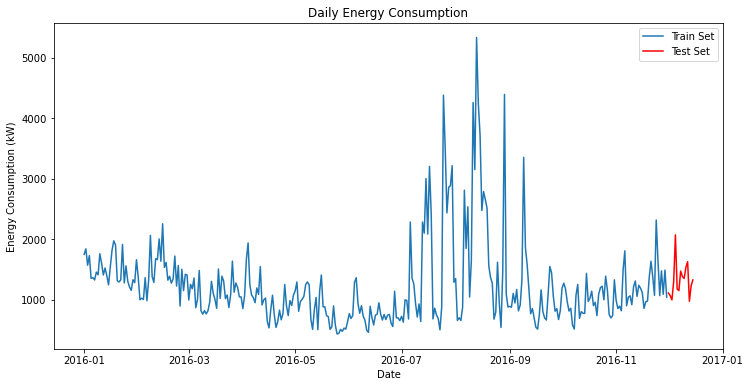

In [4]:
# Split data into training and testing
train_size = len(df_daily) - 15
train_set, test_set = df_daily.iloc[:train_size], df_daily.iloc[train_size:]
# Get time indexes
time_index_train = train_set.index.to_numpy()
time_index_test = test_set.index.to_numpy()

# Visualization of data
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, train_set['House.overall..kW.'].to_numpy(), label='Train Set')
plt.plot(time_index_test, test_set['House.overall..kW.'].to_numpy(), label='Test Set', color='r')
plt.title('Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kW)')
plt.legend()
plt.show()



/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/br/nggs341s361gy96rwgy141nc0000gn/T/ipykernel_6627/944481339.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[model_name] = train_predicted_means
/var/folders/br/nggs341s361gy96rwgy141nc0000gn/T/ipykernel_6627/944481339.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

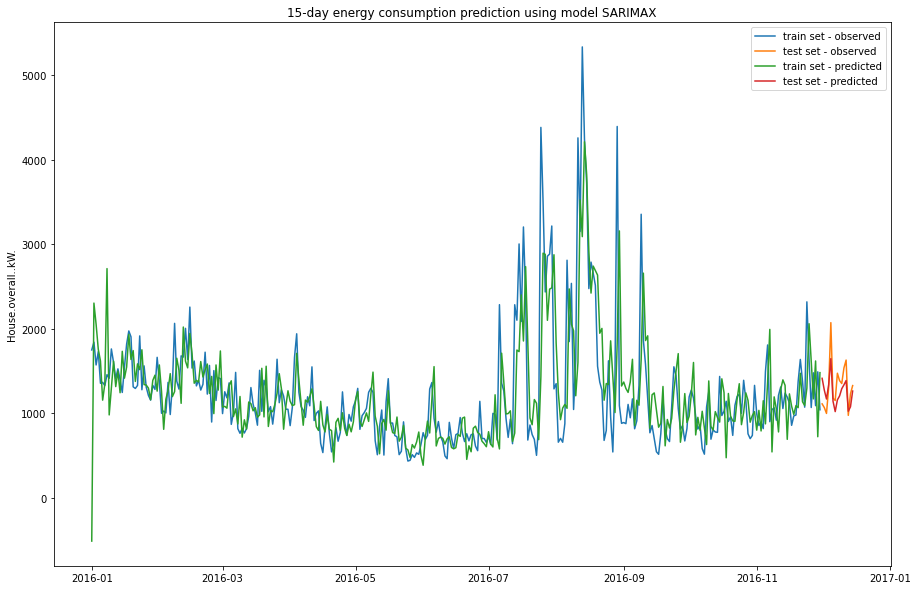

The RMSE of the model is 204.86153144856297 kW
The MAPE of the model is 12.71%
The MAE of the model is 171.61400228650018 kW


In [5]:

model_name = 'SARIMAX'
# Create SARIMAX model
sarimax_model = SARIMAX(train_set['House.overall..kW.'],
                        exog=train_set[weather_cols],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

# Fit the model
sarimax_result = sarimax_model.fit(disp=False)
#print(sarimax_result.summary())

# Predict
train_predictions = sarimax_result.get_prediction(start=train_set.index[0], end=train_set.index[-1], exog=train_set[weather_cols])
train_predicted_means = train_predictions.predicted_mean
train_set[model_name] = train_predicted_means
train_conf_int = train_predictions.conf_int()

test_predictions = sarimax_result.get_forecast(steps=15, exog=test_set[weather_cols])
predicted_means = test_predictions.predicted_mean
test_set[model_name] = predicted_means

conf_int = test_predictions.conf_int()

plot_predicted_values2('House.overall..kW.', 'SARIMAX')


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_set['House.overall..kW.'], predicted_means))
print(f'The RMSE of the model is {rmse} kW')
mape = mean_absolute_percentage_error(test_set['House.overall..kW.'], predicted_means) * 100  # Convert to percentage
print(f'The MAPE of the model is {mape:.2f}%')

# Calcular el R-squared
#r2 = r2_score(test_set['House.overall..kW.'], predicted_means)
#print(f'The R-squared of the model is {r2}')

# Calcular Mean Absolute Error (MAE)
mae = mean_absolute_error(test_set['House.overall..kW.'], predicted_means)
print(f'The MAE of the model is {mae} kW')
